# Environment

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%%bash
pip install ../optionlib

Processing /Users/dwynne891/Documents/Options/optionlib
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for optionlib: filename=optionlib-0.1.0-py3-none-any.whl size=44224 sha256=ffaa9aad9e6f9c596dfbadfc8e6629eef3e37d9ca4c944dd5a703788d9fc518d
  Stored in directory: /private/var/folders/5p/b_k1m3qs09q0s_768gjrmvvh0000gp/T/pip-ephem-wheel-cache-o7tr6r2z/wheels/4d/62/1f/11cc5573a52206189c39d7fffa7bb24e2fafc7df16a30a71e1
Successfully built optionlib
  Attempting uninstall: optionlib
    Found existing installation: optionlib 0.1.0
    Uninstalling optionlib-0.1.0:
      Successfully uninstalled optionlib-0.1.0


In [4]:
import requests as r
import pandas as pd
from datetime import datetime
import numpy as np
import plotly.express as px

In [5]:

from optionlib import floating_quantile, menus, options
from optionlib.data import prices

# Load data

In [7]:
# Load historical data

eth_prices = pd.read_parquet('price_history/btc_trade_data_cleaned.parquet')

eth_prices = eth_prices.reset_index().assign(
    bucket = lambda x: x.timestamp.dt.ceil("H"),
    DTE = lambda x: x.expiration - x.bucket,
    strike_dist = lambda x: abs(x.strike - x.index_price),
    index_return = lambda x: (x.delivery_price/x.index_price) - 1,
    abs_index_return = lambda x: x.index_return.abs()
)

In [8]:
# IV by DTE
iv_by_dte = pd.read_parquet('price_history/btc_iv_by_dte.parquet')

# Query data

In [181]:
# Option prices

currency = 'BTC'
kind = 'option'
url = f'https://www.deribit.com/api/v2/public/get_book_summary_by_currency?currency={currency}&kind={kind}'

response = r.get(url)
df_prices_raw = pd.DataFrame.from_dict(response.json()['result'])


In [182]:
# Instrument details

url = f'https://www.deribit.com/api/v2/public/get_instruments?currency={currency}&kind={kind}'

response = r.get(url)
df_instruments = pd.DataFrame.from_dict(response.json()['result'])

In [185]:
# Merge prices and instruments

keep_cols_prices = [
    'mark_iv',
    'ask_price',
    'bid_price',
    'mark_price',
    'estimated_delivery_price'
]

instruments_keep_cols = [
    'option_type',
    'strike',
    'expiration_timestamp',
]

df_prices = df_prices_raw.set_index('instrument_name')[keep_cols_prices]

df_prices = df_prices.join(
    df_instruments.set_index('instrument_name')[instruments_keep_cols]
).assign(
    expiration_timestamp = lambda x: pd.to_datetime(x.expiration_timestamp,unit = 'ms'),
    DTE = lambda x: (x.expiration_timestamp - datetime.now()).dt.ceil('H'),
    put_call = lambda x: x.option_type.str[0].str.upper(),
    strike_dist = lambda x: (x.estimated_delivery_price - x.strike).abs()
).rename(columns = {
    'ask_price':'Ask',
    'bid_price':'Bid',
    'mark_price':'Midpoint',
    'mark_iv':'IV',
    'strike':'Strike'
}).set_index(['put_call','Strike'],append = True)

# Floating quintile

In [188]:
df_prices_closest = df_prices.loc[
    df_prices.groupby(
        ['expiration_timestamp','option_type']
    ).strike_dist.idxmin()
]

asset_price = df_prices_closest.estimated_delivery_price.mode()[0]
DTE_options = df_prices_closest.DTE.unique()

print(
    'DTE options:\n',
    DTE_options
)

DTE options:
 <TimedeltaArray>
[  '0 days 10:00:00',   '1 days 10:00:00',   '2 days 10:00:00',
   '4 days 10:00:00',  '11 days 10:00:00',  '18 days 10:00:00',
  '46 days 10:00:00',  '74 days 10:00:00', '165 days 10:00:00',
 '256 days 10:00:00', '347 days 10:00:00']
Length: 11, dtype: timedelta64[ns]


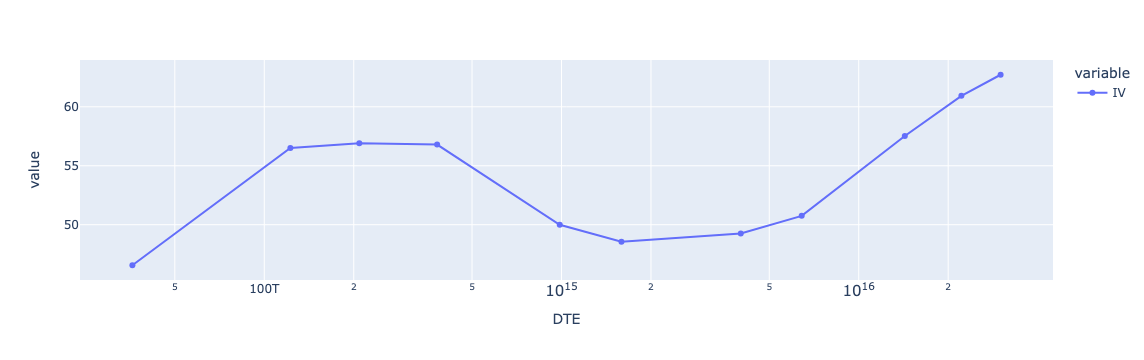

In [190]:
px.line(
    df_prices_closest.groupby('DTE').IV.mean(),
    markers= 'o',
    log_x = True
)

In [192]:
# Pick DTE index from array above

DTE = DTE_options[3]

iv = df_prices_closest.loc[
    df_prices_closest.DTE.eq(DTE),
    'IV'
].mean()

print(DTE,iv)

4 days 10:00:00 56.8


In [194]:
ntile = 5

df_prices_dte_filter = iv_by_dte.loc[
    eth_prices.DTE.eq(DTE)
].sort_values('iv')

caliper = round(df_prices_dte_filter.shape[0]/(ntile*2))



In [195]:
df_prices_dte_filter.sort_values('iv',inplace = True)

qtile_df_low = df_prices_dte_filter.where(
    lambda x: x['iv'].lt(iv)
).dropna().tail(caliper)

qtile_df_hi = df_prices_dte_filter.where(
    lambda x: x['iv'].gt(iv)
).dropna().head(caliper)

floating_quintile = pd.concat(
    [qtile_df_low,qtile_df_hi]
).index_return.quantile([round(i,2) for i in np.linspace(0.01,.99,99)])

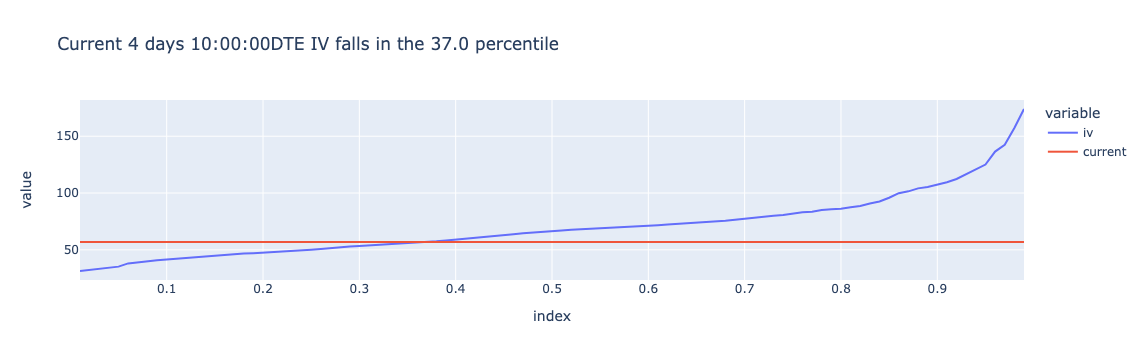

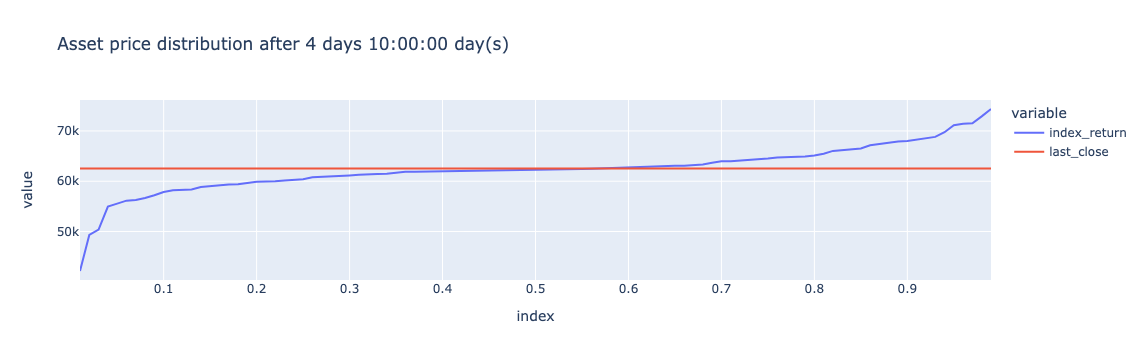

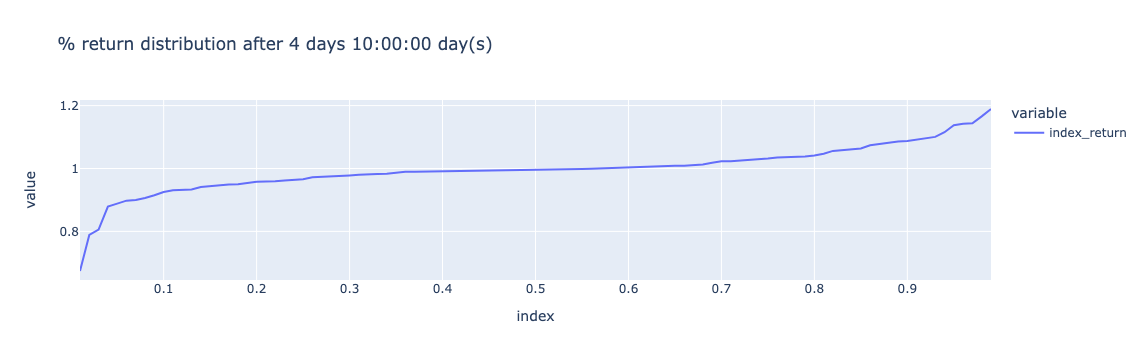

In [198]:
IV_ptiles = df_prices_dte_filter.iv.quantile(
        [round(i,2) for i in np.linspace(0.01,.99,99)]
).to_frame()

IV_ptile_current = (IV_ptiles - iv).abs().idxmin().values[0]

px.line(
    IV_ptiles.assign(current = iv),
    title = f'Current {DTE}DTE IV falls in the {round(IV_ptile_current*100,0)} percentile'
).show()

px.line(
    floating_quintile.add(1).multiply(asset_price).to_frame().assign(last_close = asset_price),
    title = f'Asset price distribution after {DTE} day(s)'
).show()

px.line(
    floating_quintile.add(1).to_frame(),
    title = f'% return distribution after {DTE} day(s)'
).show()

# Valuation

In [201]:
currency_vars = ['Bid','Ask','Midpoint']

df_prices_dte = df_prices.loc[
    df_prices.DTE.eq(DTE),
    currency_vars + ['IV']
].droplevel('instrument_name').sort_index().dropna()

df_prices_dte[currency_vars] = df_prices_dte[currency_vars] * asset_price

In [203]:
bounds = tuple(round(i) for i in floating_quintile.agg(['min','max']).add(1).multiply(asset_price))
print(bounds)

menu = menus.TradeMenu(
    df_prices_dte,
    asset_price,
    floating_quintile,
    bounds = bounds,
    midpoint_price = False,
    contract_size = 1
)

(42147, 74368)


## Iron Condors

In [206]:
max_combos = 10_000

menu.iron_condors(
#        downsample = max_combos,
        win_pct_bounds = (0,1)
)

Calculating 4667 Iron Condors...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 4667 out of 4667 | elapsed:   13.1s finished


In [208]:
menu.menu

cost  EV_arithmetic  \
strategy    leg_1   leg_2   leg_3   leg_4                                 
Iron condor 46000.0 48000.0 60000.0 66000.0 -2713.993828      65.778331   
                                    67000.0 -2864.076436      64.120490   
                            61000.0 65000.0 -1775.977528      67.520059   
                                    66000.0 -1994.847998      98.633552   
                                    67000.0 -2144.930606      96.975711   
...                                                  ...            ...   
            62000.0 62500.0 62500.0 65000.0 -1063.085140      48.020160   
                                    66000.0 -1281.955610      79.133652   
                                    67000.0 -1432.038218      77.475812   
                                    68000.0 -1525.839848      48.708662   
                            63000.0 66000.0 -1031.817930      30.319110   

                                              win_pct     max_loss  \
strategy    leg_1   leg_2   leg_3   leg_4                            
Iron condor 46000.0 48000.0 60000.0 66000.0  0.585859 -3288.606172   
                                    67000.0  0.616162 -4138.523564   
                            61000.0 65000.0  0.585859 -2226.622472   
                                    66000.0  0.626263 -3007.752002   
                                    67000.0  0.676768 -3857.669394   
...                                               ...          ...   
            62000.0 62500.0 62500.0 65000.0  0.686869 -1439.514860   
                                    66000.0  0.696970 -2220.644390   
                                    67000.0  0.696970 -3070.561782   
                                    68000.0  0.717172 -3976.760152   
                            63000.0 66000.0  0.717172 -1970.782070   

                                             EV_harmonic  kelly  
strategy    leg_1   leg_2   leg_3   leg_4                        
Iron condor 46000.0 48000.0 60000.0 66000.0     1.000468   0.10  
                                    67000.0     1.000275   0.10  
                            61000.0 65000.0     1.000900   0.10  
                                    66000.0     1.001345   0.15  
                                    67000.0     1.000983   0.10  
...                                                  ...    ...  
            62000.0 62500.0 62500.0 65000.0     1.001380   0.10  
                                    66000.0     1.001780   0.10  
                                    67000.0     1.001237   0.15  
                                    68000.0     1.000355   0.10  
                            63000.0 66000.0     1.000092   0.10  

[2822 rows x 6 columns]

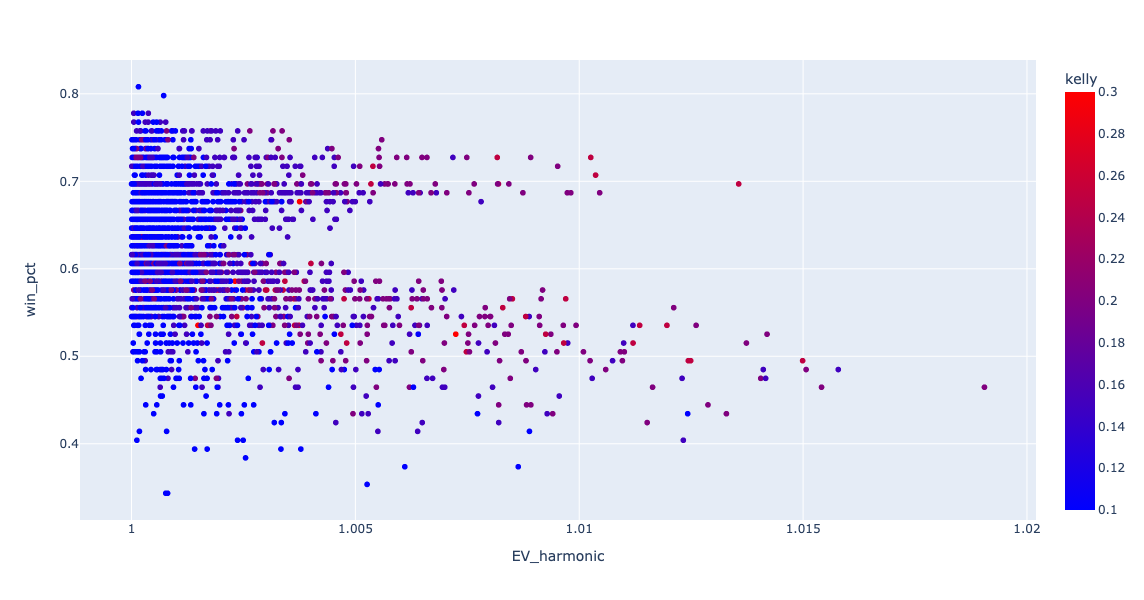

In [210]:
px.scatter(
    data_frame = menu.menu.loc['Iron condor'].reset_index(),#.sample(30000),
    x = 'EV_harmonic',
    y = 'win_pct',
    hover_data = ['leg_1','leg_2','leg_3','leg_4'],
    #opacity = 0.5,
    height = 600,
    color = 'kelly',
    color_continuous_scale=px.colors.sequential.Bluered
)

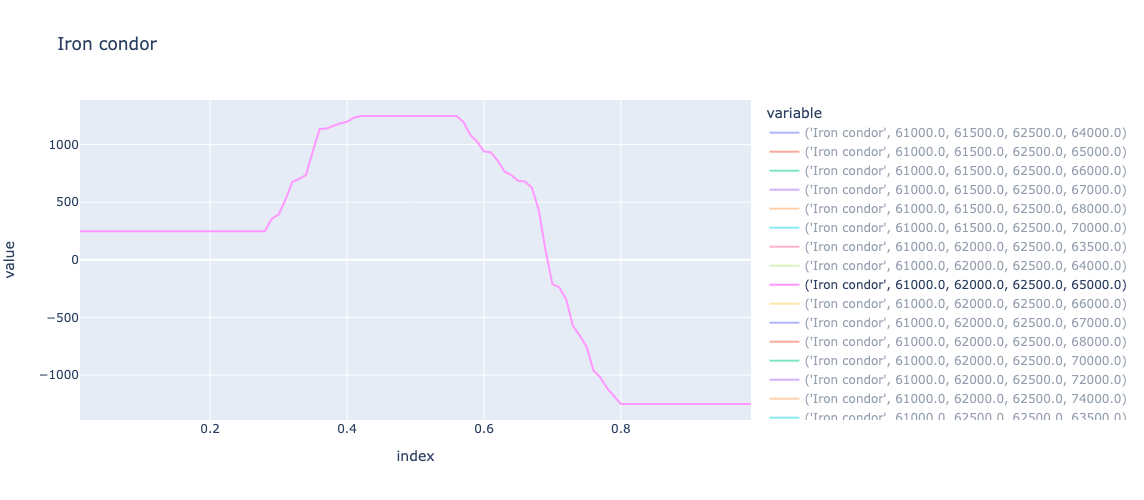

In [212]:
strategy = 'Iron condor'
val1, val2, val3, val4 =61000,62000,62500,65000
menu_slice = menu.menu_quantiles.loc[pd.IndexSlice[strategy,val1,:,val3,:],:].T

menu_slice.columns = [str(i) for i in menu_slice.columns.to_flat_index()]

plot_df = menu_slice.copy()

px.line(plot_df,height = 500,title = strategy)

## Long strategies 

In [214]:
menu.long_all()

## Spreads

In [217]:
menu.spreads()

Calculating bull call spreads ...
Calculating bull put spreads ...
Calculating bear call spreads ...
Calculating bear put spreads ...
Complete


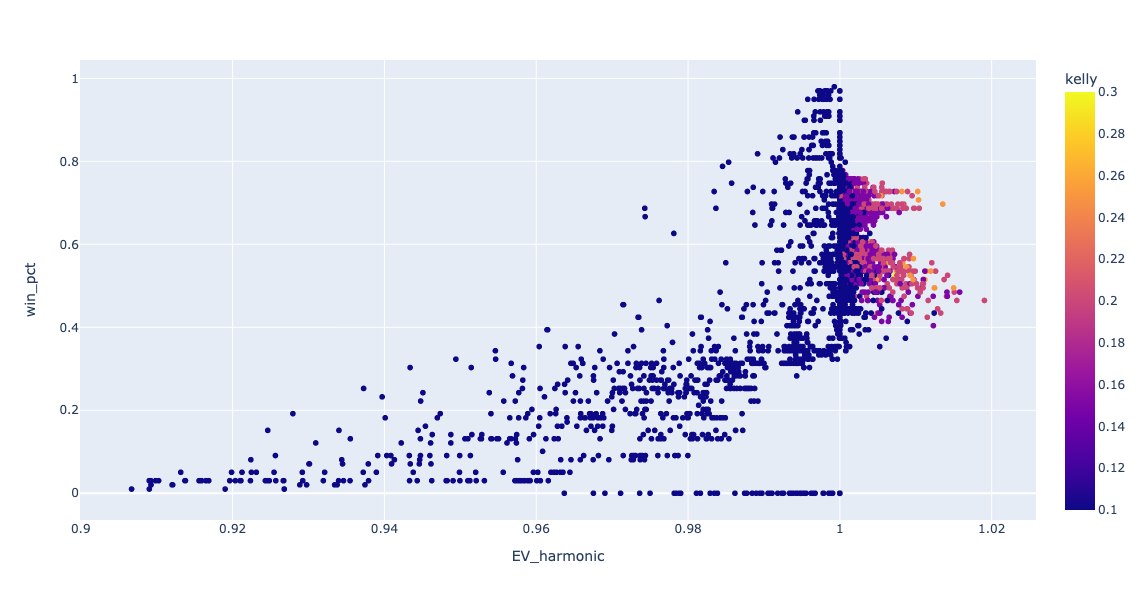

In [218]:
px.scatter(
    data_frame = menu.menu.reset_index(),#.sample(30000),
    x = 'EV_harmonic',
    y = 'win_pct',
    hover_data = ['strategy','leg_1','leg_2'],
    opacity = 1,
    height = 600,
    color = 'kelly'
)

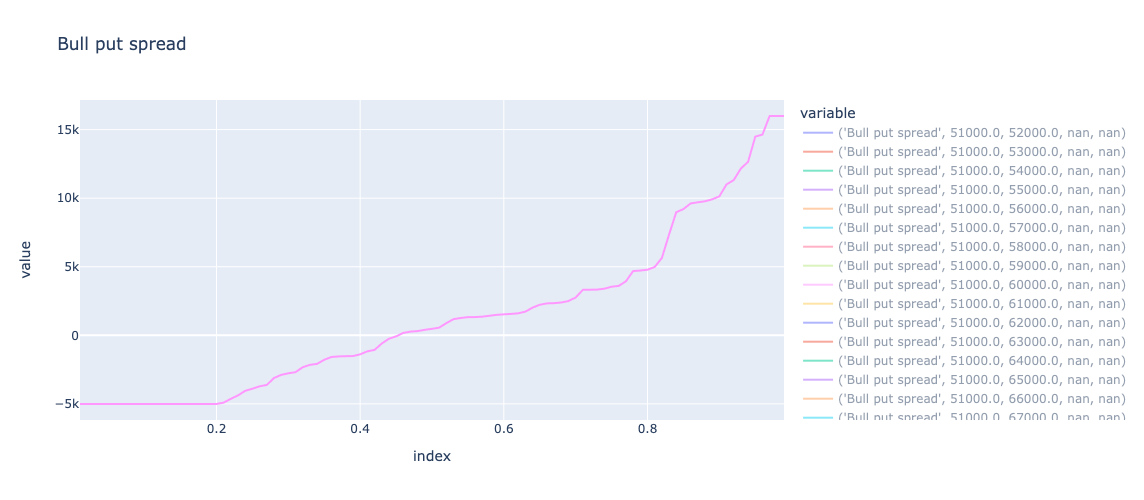

In [161]:
strategy = 'Bull put spread'
val1, val2=51000,72000

menu_slice = menu.menu_quantiles.loc[pd.IndexSlice[strategy,val1,:,:,:],:].T

menu_slice.columns = [str(i) for i in menu_slice.columns.to_flat_index()]

plot_df = menu_slice.copy()

px.line(plot_df,height = 500,title = strategy)

## Straddles/strangles

In [221]:
menu.long_strangle()

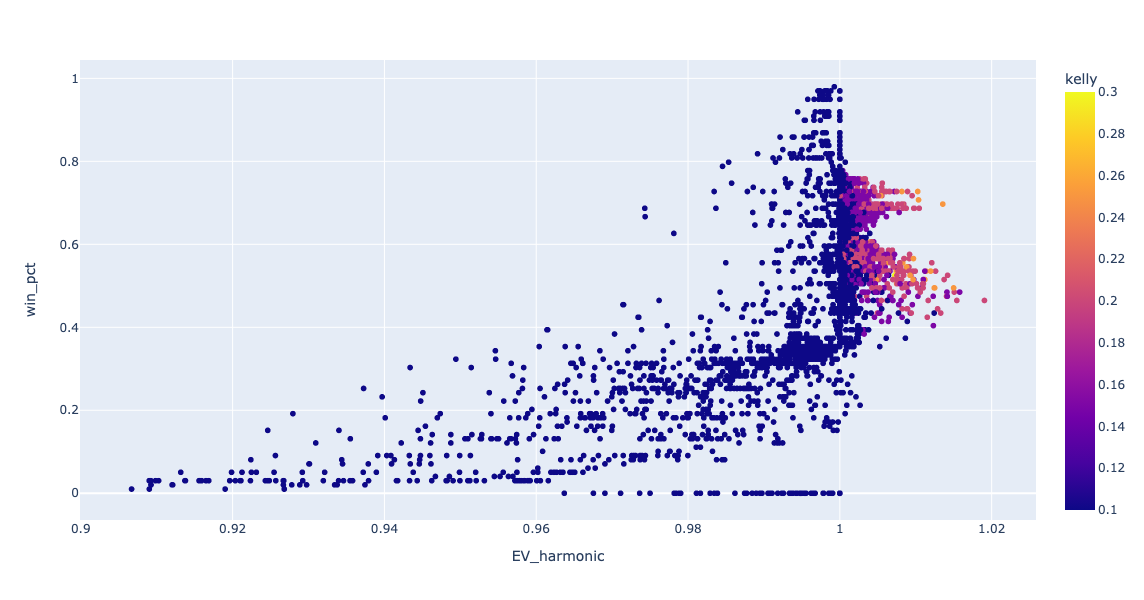

In [222]:
px.scatter(
    data_frame = menu.menu.reset_index(),
    x = 'EV_harmonic',
    y = 'win_pct',
    hover_data = ['strategy','leg_1','leg_2'],
    opacity = 1,
    height = 600,
    color = 'kelly'
)

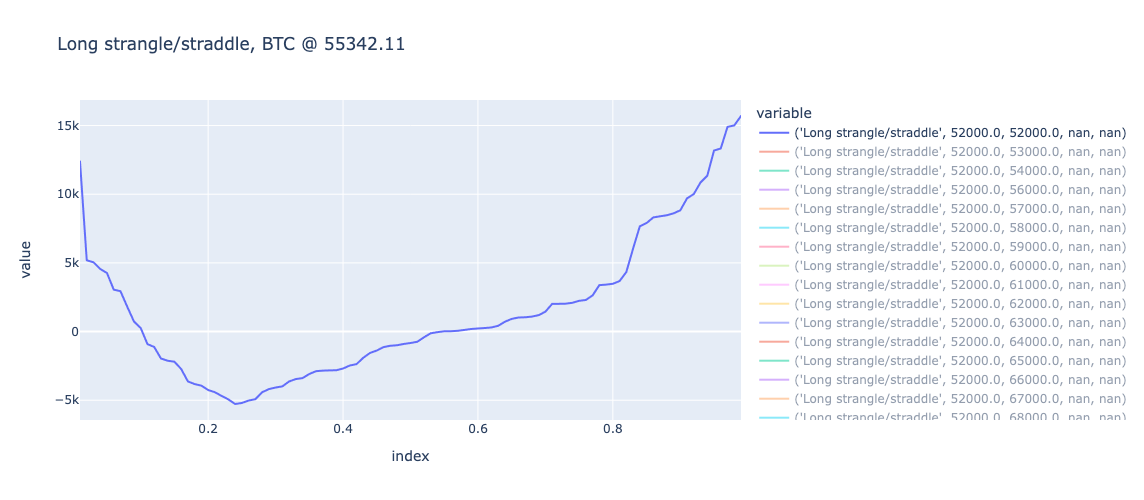

In [173]:
strategy = 'Long strangle/straddle'
val1, val2=52000,52000

menu_slice = menu.menu_quantiles.loc[pd.IndexSlice[strategy,val1,:,:,:],:].T

menu_slice.columns = [str(i) for i in menu_slice.columns.to_flat_index()]

plot_df = menu_slice.copy()

px.line(plot_df,height = 500,title = f'{strategy}, BTC @ {asset_price}')